/tmp/ipython-input-2153803790.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Downloaded rows: 717

Estimated parameters from historical data (716 daily returns):
 Current price S0 = 248.2012
 Annualized drift (mu) = 37.3772%
 Annualized volatility (sigma) = 32.1755%


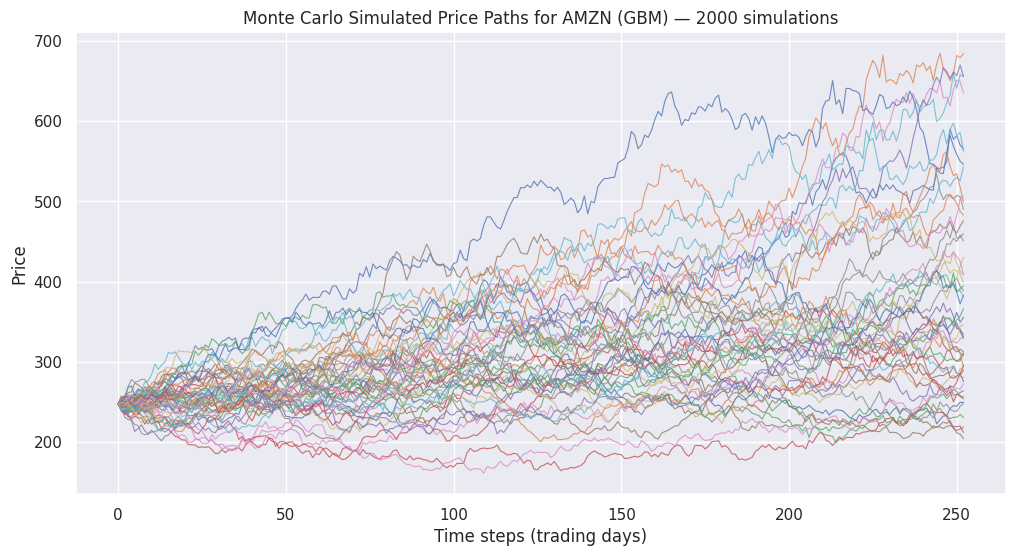

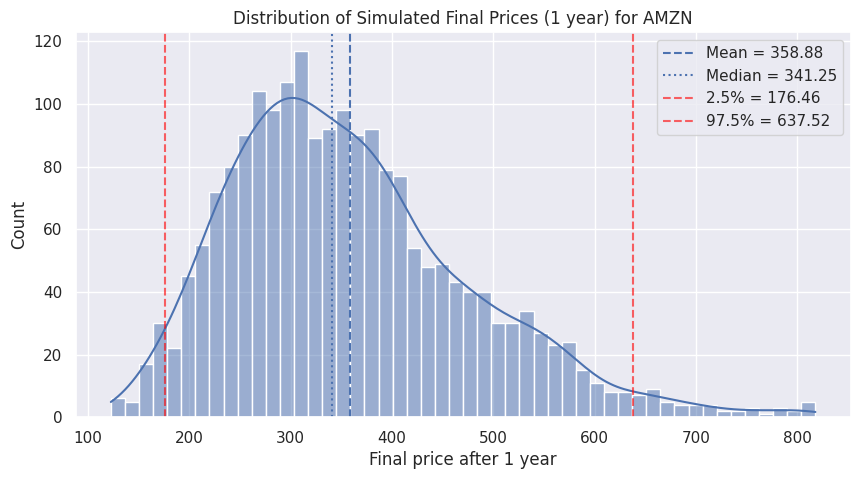

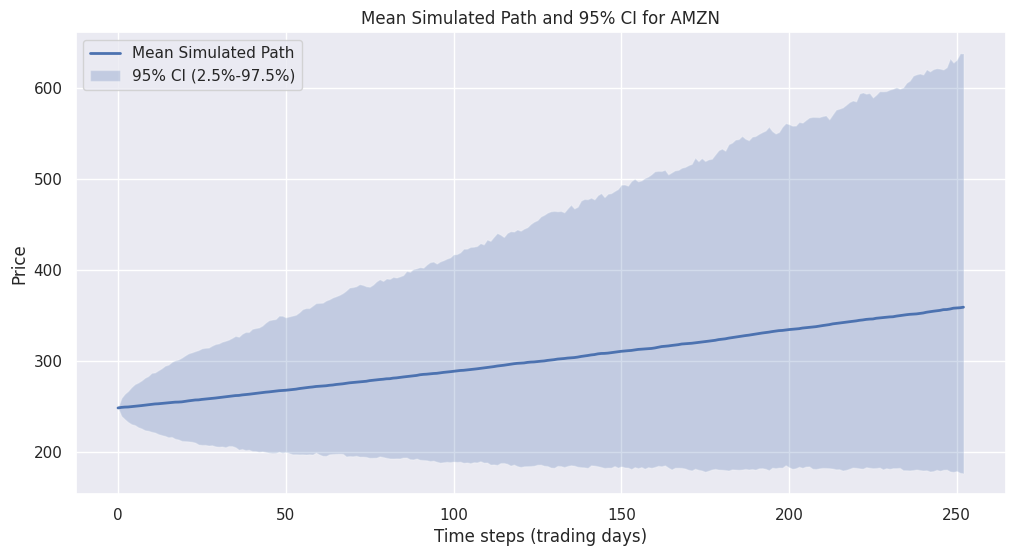

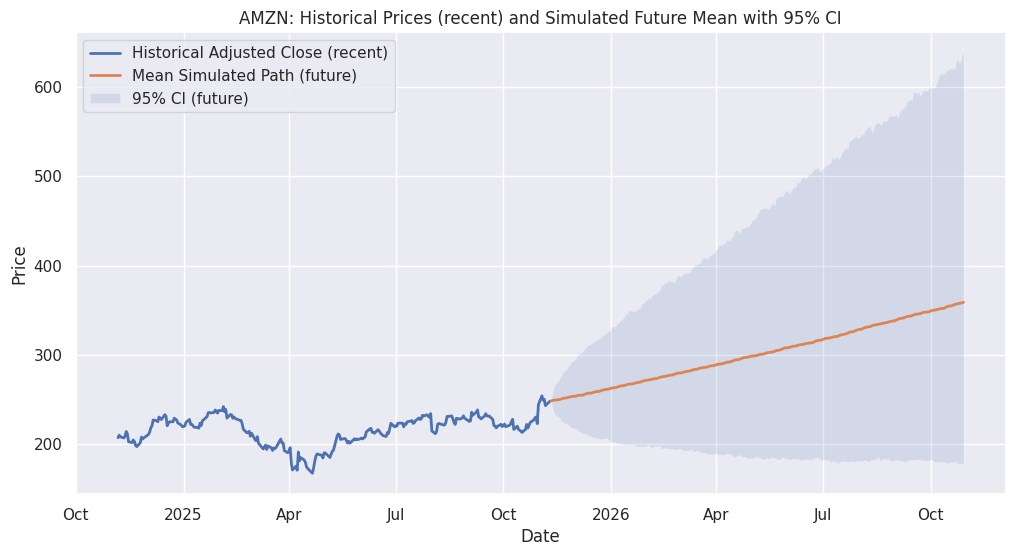

 Simulation Summary
S0 (last observed price) = 248.2012
Simulations (M) = 2000, Steps per year (N) = 252
Mean of final prices = 358.8765
Median of final prices = 341.2535
Std of final prices = 118.8369
95% CI for final price (2.5% - 97.5%) = [176.4630, 637.5241]

Note: GBM assumes constant drift and volatility — it does NOT model jumps or regime changes.


In [1]:
# Monte Carlo Stock Price Prediction (GBM) with Real Data

# Install yfinance
!pip install yfinance --quiet

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta

# Settings
ticker = "AMZN"
start_date = "2023-01-01"
end_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d") # until today
T = 1 # years to simulate (kept at 1)
N = 252 # steps per year (trading days)
M = 2000 # number of Monte Carlo simulations (kept at 2000)
random_seed = 42 # set to None for different runs each time

# Reproducibility
if random_seed is not None:
    np.random.seed(random_seed)

sns.set(style="darkgrid")


# 1) Download historical data
print(f"Downloading {ticker} data from {start_date} to {end_date} ...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

if data.empty:
    raise SystemExit("Error: No data downloaded. Check the ticker symbol or date range.")

# Prefer 'Adj Close' if available
if "Adj Close" in data.columns:
    price_series = data["Adj Close"].copy()
else:
    price_series = data["Close"].copy()

price_series = price_series.dropna()
if price_series.empty:
    raise SystemExit("Error: Adjusted/Close price series is empty after dropping NA values.")

print("Downloaded rows:", len(price_series))


# 2) Estimate mu (drift) and sigma (volatility) from log returns
log_returns = np.log(price_series / price_series.shift(1)).dropna()
if log_returns.empty:
    raise SystemExit("Error: Not enough data to compute log returns.")

# Annualize (assuming 252 trading days)
trading_days = 252
mu = log_returns.mean() * trading_days # annualized expected log return
sigma = log_returns.std(ddof=1) * np.sqrt(trading_days) # annualized volatility (sample std)

S0 = price_series.iloc[-1] # last available price as starting point

print(f"\nEstimated parameters from historical data ({len(log_returns)} daily returns):")
print(f" Current price S0 = {S0.iloc[0]:.4f}")
print(f" Annualized drift (mu) = {mu.iloc[0]:.4%}")
print(f" Annualized volatility (sigma) = {sigma.iloc[0]:.4%}")


# 3) Monte Carlo Simulation (GBM)
dt = T / N
S = np.zeros((N + 1, M))
S[0] = S0

# vectorized simulation: generate (N, M) standard normal variates
Z = np.random.standard_normal((N, M))

# Use the discrete GBM update: S_t+1 = S_t * exp((mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z)
drift_term = (mu.iloc[0] - 0.5 * sigma.iloc[0]**2) * dt
stochastic_term = sigma.iloc[0] * np.sqrt(dt) * Z
# cumulative multiplication for each path
logS = np.log(S0.iloc[0]) + np.cumsum(drift_term + stochastic_term, axis=0)
S = np.exp(np.vstack([np.log(S0.iloc[0])*np.ones((1, M)), logS])) # include t=0 row


# 4) Visualizations
import matplotlib.dates as mdates

# A) Plot a selection of simulated paths
plt.figure(figsize=(12, 6))
n_plot = min(50, M) # number of sample paths to plot
plt.plot(S[:, :n_plot], linewidth=0.8, alpha=0.8)
plt.title(f"Monte Carlo Simulated Price Paths for {ticker} (GBM) — {M} simulations")
plt.xlabel("Time steps (trading days)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# B) Histogram + KDE of final prices
final_prices = S[-1, :]
plt.figure(figsize=(10, 5))
sns.histplot(final_prices, bins=50, kde=True)
mean_final = final_prices.mean()
median_final = np.median(final_prices)
p2_5, p97_5 = np.percentile(final_prices, [2.5, 97.5])
plt.axvline(mean_final, linestyle='--', label=f"Mean = {mean_final:.2f}")
plt.axvline(median_final, linestyle=':', label=f"Median = {median_final:.2f}")
plt.axvline(p2_5, color='red', linestyle='--', alpha=0.6, label=f"2.5% = {p2_5:.2f}")
plt.axvline(p97_5, color='red', linestyle='--', alpha=0.6, label=f"97.5% = {p97_5:.2f}")
plt.title(f"Distribution of Simulated Final Prices (1 year) for {ticker}")
plt.xlabel("Final price after 1 year")
plt.legend()
plt.show()

# C) Mean path with 95% confidence band (percentiles)
mean_path = S.mean(axis=1)
lower_path = np.percentile(S, 2.5, axis=1)
upper_path = np.percentile(S, 97.5, axis=1)

plt.figure(figsize=(12, 6))
x = np.arange(0, N + 1)
plt.plot(x, mean_path, label="Mean Simulated Path", linewidth=2)
plt.fill_between(x, lower_path, upper_path, alpha=0.25, label="95% CI (2.5%-97.5%)")
plt.title(f"Mean Simulated Path and 95% CI for {ticker}")
plt.xlabel("Time steps (trading days)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# D) Compare with historical price trajectory (resampled to match N steps for visual alignment)
plt.figure(figsize=(12, 6))
# historical series for plotting
hist_prices = price_series.copy()
hist_dates = hist_prices.index

# plot historical recent portion equal to length N (if enough data)
hist_plot_len = min(len(hist_prices), N + 1)
hist_to_plot = hist_prices[-hist_plot_len:]

plt.plot(hist_to_plot.index, hist_to_plot.values, label="Historical Adjusted Close (recent)", linewidth=2)

# overlay mean simulated path but aligned to dates: create date index from last historical date forward
last_date = hist_prices.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=N + 1) # business days
# use mean_path[1:] for future days (exclude t=0 which is S0 aligned with last_date)
plt.plot(future_dates, mean_path, label="Mean Simulated Path (future)", linewidth=2)
plt.fill_between(future_dates, lower_path, upper_path, alpha=0.15, label="95% CI (future)")

plt.title(f"{ticker}: Historical Prices (recent) and Simulated Future Mean with 95% CI")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
plt.grid(True)
plt.show()


# 5) Summary statistics printed
print(" Simulation Summary")
print(f"S0 (last observed price) = {S0.iloc[0]:.4f}")
print(f"Simulations (M) = {M}, Steps per year (N) = {N}")
print(f"Mean of final prices = {mean_final:.4f}")
print(f"Median of final prices = {median_final:.4f}")
print(f"Std of final prices = {final_prices.std(ddof=1):.4f}")
print(f"95% CI for final price (2.5% - 97.5%) = [{p2_5:.4f}, {p97_5:.4f}]")
print("\nNote: GBM assumes constant drift and volatility — it does NOT model jumps or regime changes.")

In [2]:
pd.DataFrame(price_series)

Ticker,AMZN
Date,
2023-01-03,85.820000
2023-01-04,85.139999
2023-01-05,83.120003
2023-01-06,86.080002
2023-01-09,87.360001
...,...
2025-11-04,249.320007
2025-11-05,250.199997
2025-11-06,243.039993


In [3]:
price_series


Ticker,AMZN
Date,
2023-01-03,85.820000
2023-01-04,85.139999
2023-01-05,83.120003
2023-01-06,86.080002
2023-01-09,87.360001
...,...
2025-11-04,249.320007
2025-11-05,250.199997
2025-11-06,243.039993


In [4]:
final_prices

array([565.15165855, 334.81469218, 231.00305362, ..., 256.38373486,
       256.51690971, 317.84266283])